In [1]:
from common.multiprocessing_env import SubprocVecEnv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gym
import datetime
import os

2023-04-08 17:58:58.916193: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-08 17:58:58.942292: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 17:58:59.329576: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# env = gym.make('CarRacing-v0')
# env.reset()
# while True:
#     env.render()
#     state, reward, done, _ = env.step([0, 1, 0])
#     if done:
#         break

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
tf.config.list_physical_devices('GPU')

2023-04-08 17:59:00.000822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-08 17:59:00.017434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-08 17:59:00.017576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
num_envs = 4
env_name = "CarRacing-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env_test = gym.make(env_name)

input_dim = (64, 64, 3)
output_dim = 5

/home/nimahsn/Documents/RL/lusr_carracing/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nimahsn/Documents/RL/lusr_carracing/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nimahsn/Documents/RL/lusr_carracing/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nimahsn/Documents/RL/lusr_carracing/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nimahsn/Documents/RL/lusr_carracing/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
env_test.action_space # Steering (-1 to 1), Gas (0 to 1), Brake (0 to 1)

Box(3,)

In [7]:
# convert to discrete action space with 5 actions: left, right, forward, brake, no action
# 0: left, 1: right, 2: forward, 3: brake, 4: no action
def convert_to_continuous_action(action, batch=False):
    if batch:
        return np.array([convert_to_continuous_action(a) for a in action])
    if action == 0:
        return [-1., 0., 0.]
    elif action == 1:
        return [1., 0., 0.]
    elif action == 2: # forward
        return [0., 8.0, 0.0]
    elif action == 3:
        return [0., 0., 0.8]
    elif action == 4:
        return [0., 0., 0.]    

In [8]:
def preprocess_state(state, batch=True):
    if batch:
        state = state[:, :84, ...]
    else:
        state = state[:84, ...]
    state = state / 255.0
    state = tf.image.resize(state, (64, 64),)
    return state

In [9]:
PADDING = 'valid'
ACTIVATION = 'relu'

class ActorCriticPPO(tf.keras.Model):
    def __init__(self, input_dim, n_actions):
        super(ActorCriticPPO, self).__init__()
        self.input_dim = input_dim
        self.n_actions = n_actions

        self.commons = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_dim),
            tf.keras.layers.Conv2D(32, 4, 2, activation=ACTIVATION, padding=PADDING),
            tf.keras.layers.Conv2D(64, 4, 2, activation=ACTIVATION, padding=PADDING),
            tf.keras.layers.Conv2D(128, 4, 2, activation=ACTIVATION, padding=PADDING),
            tf.keras.layers.Conv2D(256, 4, 2, activation=ACTIVATION, padding=PADDING),
            tf.keras.layers.Flatten()
        ])

        self.actor = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation=ACTIVATION),
            tf.keras.layers.Dense(256, activation=ACTIVATION),
            tf.keras.layers.Dense(n_actions, activation='softmax')
        ])

        self.critic = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation=ACTIVATION),
            tf.keras.layers.Dense(256, activation=ACTIVATION),
            tf.keras.layers.Dense(1)
        ])

    def call(self, inputs, training=False):
        x = self.commons(inputs, training=training)
        return self.actor(x, training=training), self.critic(x, training=training)
    
    def act(self, state, training=False):
        logits, _ = self.call(state, training=training)
        action = tf.random.categorical(logits, 1)[0, 0]
        return action.numpy()

In [10]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5), dpi=100)
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    # plt.subplot(132)
    # plt.title('loss')
    # plt.plot(losses)
    plt.savefig(f'./plots/{frame_idx}.png')
    plt.show()

def run_test_env(model: ActorCriticPPO, env, vis=False):
    """
    Run the environment for one episode and return the total reward.

    Args:
        model: The model to use for inference.
        env: The environment to run.
        vis: Whether to render the environment.
    """
    state = preprocess_state(env.reset(), batch=False)
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        policy, _ = model(state[None, ...])
        #deterministic action
        action = np.argmax(policy)
        next_state, reward, done, _ = env.step(convert_to_continuous_action(action))
        if reward < 0:
            reward = -0.1
        state = preprocess_state(next_state, batch=False)
        if vis: env.render()
        total_reward += reward
    return total_reward    

In [11]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    """
    Generalized Advantage Estimate

    Args:
        next_value: V(s_{t+1}) -- the critic's estimate of what the future state's value is
        rewards: [r_{t}, r_{t+1}, ..., r_{T-1}]
        masks: [m_{t}, m_{t+1}, ..., m_{T-1}]
        values: [V(s_{t}), V(s_{t+1}), ..., V(s_{T-1})]
        gamma: discount factor
        tau: GAE-lambda

    Returns:
        returns: [GAE_{t}, GAE_{t+1}, ..., GAE_{T-1}]
    """
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

In [12]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.shape[0]
    # for _ in range(batch_size // mini_batch_size):
    #     rand_ids = np.random.randint(0, batch_size, mini_batch_size)
    #     yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
    shuffle_ids = np.random.permutation(batch_size)
    for i in range(0, batch_size, mini_batch_size):
        yield tf.gather(states, shuffle_ids[i:i+mini_batch_size]), tf.gather(actions, shuffle_ids[i:i+mini_batch_size]), tf.gather(log_probs, shuffle_ids[i:i+mini_batch_size]), tf.gather(returns, shuffle_ids[i:i+mini_batch_size]), tf.gather(advantage, shuffle_ids[i:i+mini_batch_size])
        
def ppo_update(model, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for j in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            with tf.GradientTape() as tape:
                probs, value = model(state)
                value = tf.squeeze(value)
                entropy = -tf.reduce_mean(tf.reduce_sum(probs * tf.math.log(probs), axis=1))
                new_log_probs = tf.math.log(tf.reduce_sum(probs * action, axis=1, keepdims=False))
                ratio = tf.exp(new_log_probs - old_log_probs)
                surr1 = ratio * advantage
                # surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage # convert to tf
                surr2 = tf.clip_by_value(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

                # actor_loss  = - torch.min(surr1, surr2).mean()
                actor_loss  = - tf.reduce_mean(tf.minimum(surr1, surr2))

                # critic_loss = (return_ - value).pow(2).mean()
                critic_loss = tf.reduce_mean(tf.square(return_ - value))

                loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            grads = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # log
        if j % 20 == 0:
            print(f'Epoch {j} loss: {loss.numpy()} actor_loss: {actor_loss.numpy()} critic_loss: {critic_loss.numpy()} entropy: {entropy.numpy()}')



In [13]:
# model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)


In [13]:
lr = 2e-5
model = ActorCriticPPO(input_dim, output_dim)
optimizer = tf.keras.optimizers.Adam(lr)
model.compile(optimizer=optimizer)

#Hyper params:
num_steps        = 1000
mini_batch_size  = 500
ppo_epochs       = 100
threshold_reward = -50

max_frames = 100000
frame_idx  = 75000
test_rewards = []

2023-04-08 17:59:07.389983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-08 17:59:07.390174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-08 17:59:07.390238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [15]:
model.commons

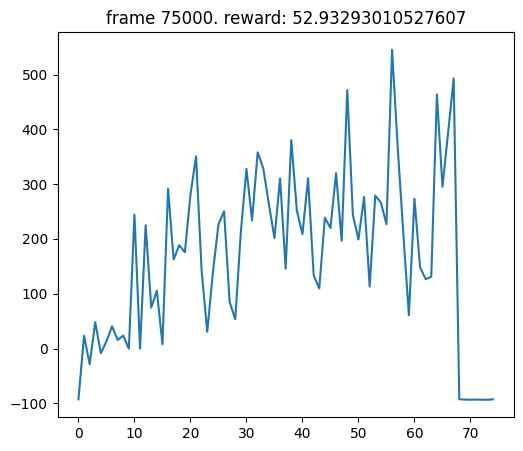

Epoch 0 loss: nan actor_loss: nan critic_loss: nan entropy: nan
Epoch 20 loss: nan actor_loss: nan critic_loss: nan entropy: nan
Epoch 40 loss: nan actor_loss: nan critic_loss: nan entropy: nan
Epoch 60 loss: nan actor_loss: nan critic_loss: nan entropy: nan
Epoch 80 loss: nan actor_loss: nan critic_loss: nan entropy: nan

Frame_idx: 75000, entropy: nan, reward: -0.3718160086117058

reset


KeyboardInterrupt: 

In [16]:
state = preprocess_state(envs.reset(), True)
early_stop = False # set to true if the reward is above the threshold

total_rewards = []
total_returns = []

while frame_idx < max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        # state = state
        policy, value = model(state) # policy = [batch_size, num_actions], value = [batch_size, 1]. policy is the probability of each action
        value = tf.squeeze(value)
        action = tf.random.categorical(policy, 1).numpy()
        reward = np.array([0.0]*num_envs)
        for _ in range(4):
            next_state, reward_t, done, _ = envs.step(convert_to_continuous_action(action, True))
            rewards_t = np.where(reward_t < 0, [-0.1]*num_envs, reward_t)
            reward += reward_t
            if done.any():
                break
        
        one_hot_action = tf.squeeze(tf.one_hot(action, output_dim))

        # calculate the log prob of the selected action based on the the policy
        log_prob = tf.math.log(tf.reduce_sum(one_hot_action * policy, axis=1))
        entropy += tf.reduce_mean(-tf.reduce_sum(policy * tf.math.log(policy), axis=1))

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(reward)
        masks.append(1 - done)

        states.append(state)
        actions.append(one_hot_action)

        next_state = preprocess_state(next_state, batch=True)
        state = next_state
        frame_idx += 1

        if frame_idx % 1000 == 0:
            test_reward = np.mean([run_test_env(model, env_test, False) for _ in range(2)])
            test_rewards.append(test_reward)
            plot(frame_idx, test_rewards)
            # if test_reward > threshold_reward: early_stop = True

        # save checkpoint every 5000 frames
        if frame_idx % 5000 == 0:
            # detect if weights are nan or inf because of exploding gradients, if not save weights
            os.mkdir(f'./checkpoints/{frame_idx}')
            os.mkdir(f'./checkpoints/{frame_idx}/commons')
            os.mkdir(f'./checkpoints/{frame_idx}/actor')
            os.mkdir(f'./checkpoints/{frame_idx}/critic')
            
            model.commons.save_weights(f'./checkpoints/{frame_idx}/commons/weights.h5')
            model.actor.save_weights(f'./checkpoints/{frame_idx}/actor/weights.h5')
            model.critic.save_weights(f'./checkpoints/{frame_idx}/critic/weights.h5')
            # else :
            #     print('Weights are nan or inf, not saving checkpoint')
            #     early_stop = True
            #     break

    # next_state = preprocess_state(next_state, batch=True)
    _, next_value = model(next_state)
    next_value = tf.squeeze(next_value)
    returns = compute_gae(next_value, rewards, masks, values)

    # print(rewards[0].shape, returns[0].shape, values[0].shape, states[0].shape, actions[0].shape, log_probs[0].shape)
    #log total reward for each worker
    # print(f'worker 0 reward: {rewards[:][0]}')

    total_rewards.append(np.sum(rewards, axis=0))
    total_returns.append(np.sum(returns, axis=0))

    log_probs = tf.concat(log_probs, axis=0)
    returns   = tf.concat(returns, axis=0)
    values    = tf.concat(values, axis=0)
    states    = tf.concat(states, axis=0)
    actions   = tf.concat(actions, axis=0)
    advantage = tf.convert_to_tensor(returns - values)


    ppo_update(model, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)
    #log 
    print(f'\nFrame_idx: {frame_idx}, entropy: {entropy.numpy()}, reward: {np.mean(rewards)}\n')

    if done.all():
        state = preprocess_state(envs.reset(), True)
        print('reset')
    else:
        state = next_state

# save the model
model.commons.save_weights('ppo_model_commons.h5')
model.actor.save_weights('ppo_model_actor.h5')
model.critic.save_weights('ppo_model_critic.h5')
    

In [14]:
model.build([None, 64, 64, 3])

In [15]:
model.commons.load_weights('./65000/commons/weights.h5')
model.actor.load_weights('./65000/actor/weights.h5')
model.critic.load_weights('./65000/critic/weights.h5')

In [21]:
run_test_env(model, env_test, True)

Track generation: 1367..1713 -> 346-tiles track


152.1739130434836

In [39]:
lr = 5e-6
# model = ActorCriticPPO(input_dim, output_dim)
optimizer = tf.keras.optimizers.Adam(lr)
model.compile(optimizer=optimizer)

max_frames = 100000
frame_idx  = 65000
# test_rewards = []
model.commons
state = preprocess_state(envs.reset(), True)
early_stop = False # set to true if the reward is above the threshold

# total_rewards_2 = []
# total_returns_2 = []

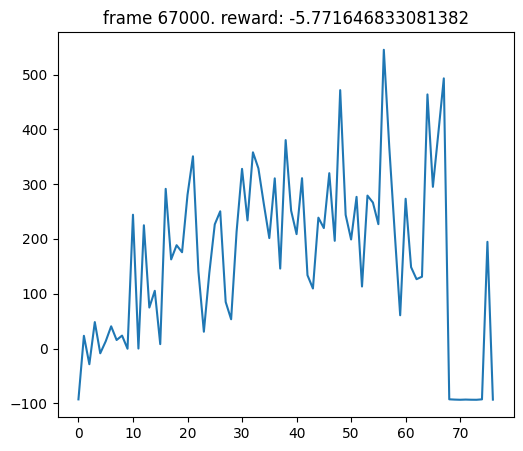

Epoch 0 loss: nan actor_loss: nan critic_loss: nan entropy: nan
Epoch 20 loss: nan actor_loss: nan critic_loss: nan entropy: nan
Epoch 40 loss: nan actor_loss: nan critic_loss: nan entropy: nan
Epoch 60 loss: nan actor_loss: nan critic_loss: nan entropy: nan
Epoch 80 loss: nan actor_loss: nan critic_loss: nan entropy: nan

Frame_idx: 67000, entropy: nan, reward: -0.37046792991631083



KeyboardInterrupt: 

In [32]:
while frame_idx < max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        # state = state
        policy, value = model(state) # policy = [batch_size, num_actions], value = [batch_size, 1]. policy is the probability of each action
        value = tf.squeeze(value)
        action = tf.random.categorical(policy, 1).numpy()
        reward = np.array([0.0]*num_envs)
        for _ in range(4):
            next_state, reward_t, done, _ = envs.step(convert_to_continuous_action(action, True))
            rewards_t = np.where(reward_t < 0, [-0.1]*num_envs, reward_t)
            reward += reward_t
            if done.any():
                break
        
        one_hot_action = tf.squeeze(tf.one_hot(action, output_dim))

        # calculate the log prob of the selected action based on the the policy
        log_prob = tf.math.log(tf.reduce_sum(one_hot_action * policy, axis=1))
        entropy += tf.reduce_mean(-tf.reduce_sum(policy * tf.math.log(policy), axis=1))

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(reward)
        masks.append(1 - done)

        states.append(state)
        actions.append(one_hot_action)

        next_state = preprocess_state(next_state, batch=True)
        state = next_state
        frame_idx += 1

        if frame_idx % 1000 == 0:
            test_reward = np.mean([run_test_env(model, env_test, False) for _ in range(2)])
            test_rewards.append(test_reward)
            plot(frame_idx, test_rewards)
            # if test_reward > threshold_reward: early_stop = True

        # save checkpoint every 5000 frames
        if frame_idx % 5000 == 0:
            # detect if weights are nan or inf because of exploding gradients, if not save weights
            os.mkdir(f'./checkpoints/{frame_idx}')
            os.mkdir(f'./checkpoints/{frame_idx}/commons')
            os.mkdir(f'./checkpoints/{frame_idx}/actor')
            os.mkdir(f'./checkpoints/{frame_idx}/critic')
            
            model.commons.save_weights(f'./checkpoints/{frame_idx}/commons/weights.h5')
            model.actor.save_weights(f'./checkpoints/{frame_idx}/actor/weights.h5')
            model.critic.save_weights(f'./checkpoints/{frame_idx}/critic/weights.h5')
            # else :
            #     print('Weights are nan or inf, not saving checkpoint')
            #     early_stop = True
            #     break

    # next_state = preprocess_state(next_state, batch=True)
    _, next_value = model(next_state)
    next_value = tf.squeeze(next_value)
    returns = compute_gae(next_value, rewards, masks, values)

    # print(rewards[0].shape, returns[0].shape, values[0].shape, states[0].shape, actions[0].shape, log_probs[0].shape)
    #log total reward for each worker
    # print(f'worker 0 reward: {rewards[:][0]}')

    total_rewards.append(np.sum(rewards, axis=0))
    total_returns.append(np.sum(returns, axis=0))

    log_probs = tf.concat(log_probs, axis=0)
    returns   = tf.concat(returns, axis=0)
    values    = tf.concat(values, axis=0)
    states    = tf.concat(states, axis=0)
    actions   = tf.concat(actions, axis=0)
    advantage = tf.convert_to_tensor(returns - values)


    ppo_update(model, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)
    #log 
    print(f'\nFrame_idx: {frame_idx}, entropy: {entropy.numpy()}, reward: {np.mean(rewards)}\n')

    if done.all():
        state = preprocess_state(envs.reset(), True)
        print('reset')
    else:
        state = next_state

# save the model
model.commons.save_weights('ppo_model_commons.h5')
model.actor.save_weights('ppo_model_actor.h5')
model.critic.save_weights('ppo_model_critic.h5')
    

In [ ]:
total_returns

[array([ -941.8509 , -1060.6156 , -1011.5072 ,  -782.34845], dtype=float32)]

In [ ]:
arr = np.array(total_returns)
#save arr
np.save('ppo_total_returns.npy', arr)

In [ ]:
arr = np.array(total_rewards)
#save arr
np.save('ppo_total_rewards.npy', arr)